In [1]:
# ============================================================
# Trial15: Trial14 + (1) Damage-proxy features + (2) Tail-robust training
#
# 핵심 아이디어:
# - Trial14 결과에서 모델이 tail 구간에 과의존( mask_tail 시 RMSE 폭발 )하는 경향이 강함.
# - 해결:
#   (1) min_vce만으로도 "누적 손상(damage)"을 나타내는 proxy feature 추가 (process 정보)
#   (2) 훈련에서 tail 일부를 랜덤하게 마스킹/셔플 -> tail shortcut 방지, tail shift에 강해짐
#
# Keeps Trial9 evaluation pack: PH / α–λ / CRA / convergence + paper figures
#
# Folder:
#   ./Trial15/seed_<seed>/best_by_val_norm/...
#   ./Trial15/seed_<seed>/last_epoch/...
# ============================================================

import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


# ============================================================
# 0) Reproducibility
# ============================================================
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ============================================================
# 1) Config
# ============================================================
@dataclass
class Config:
    data_dir: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
    out_dir: str = r"./Trial15"

    # seeds to sweep
    seeds: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # sliding window
    seq_len: int = 100
    stride: int = 5
    pred_horizon: int = 0

    # split by FILE
    train_ratio: float = 0.7
    val_ratio: float = 0.2
    test_ratio: float = 0.1

    # training
    batch_size: int = 512
    epochs: int = 300
    lr: float = 1e-3
    weight_decay: float = 0.0
    patience: int = 30
    grad_clip: float = 1.0

    # model
    hidden_size: int = 512
    num_layers: int = 2
    dropout: float = 0.2

    # data loading
    num_workers: int = 0

    # output controls
    save_figures: bool = True
    max_files_to_plot: Optional[int] = None  # None=all

    # ===========================
    # Trial9-style Evaluation settings
    # ===========================
    alpha: float = 0.20
    ph_consecutive_m: int = 5
    rep_method: str = "mean"
    lambdas: Tuple[float, ...] = (0.2, 0.4, 0.6, 0.8)
    lambda_to_plot: float = 0.6
    eps_rul: float = 1e-8

    # ===========================
    # Trial13 base features (min_vce only)
    # ===========================
    delta_steps: Tuple[int, ...] = (1, 5, 20, 50)
    ema_spans: Tuple[int, ...] = (10, 50)
    roll_std_window: int = 10
    add_window_stats: bool = True

    # ===========================
    # Trial15-1: Damage-proxy features (min_vce only)
    # ===========================
    add_damage_proxy: bool = True
    # vce_rel = vce - vce0
    # cum_pos = cumsum(max(delta_1,0))
    # cum_abs = cumsum(abs(delta_1))
    # cum_inc = cumsum(max(vce - vce0,0))
    # cum_acc = cumsum(abs(d(delta_1)))  (2차 변화량 누적)

    # ===========================
    # Temporal Pooling (Trial14 유지)
    # ===========================
    pooling: str = "mean_last_k"   # "last" | "mean_last_k" | "attn"
    pool_last_k: int = 10
    attn_dim: int = 128

    # ===========================
    # Trial15-2: Tail-robust training (shortcut 방지)
    # ===========================
    tail_robust_enable: bool = True
    tail_k_max: int = 10                # tail_k ~ Uniform(0..tail_k_max)
    tail_apply_p: float = 1.0           # 배치마다 tail perturb 적용 확률
    tail_mode: str = "mask"             # "mask" | "shuffle"
    tail_mask_value: float = 0.0        # scaled space에서 마스킹 값


# ============================================================
# 2) Data utils
# ============================================================
def list_csv_files(data_dir: str) -> List[Path]:
    p = Path(data_dir)
    files = sorted([f for f in p.glob("*.csv") if f.is_file()])
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {data_dir}")
    return files


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected at least 2 columns, got {df.shape[1]}")
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()

    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch vce={len(vce)}, rul={len(rul)}")
    if len(vce) < 5:
        raise ValueError(f"{csv_path.name}: too short sequence length={len(vce)}")
    return vce, rul


def split_files(
    files: List[Path],
    train_ratio: float,
    val_ratio: float,
    test_ratio: float,
    seed: int
) -> Dict[str, List[Path]]:
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    rng = random.Random(seed)
    files_shuffled = files[:]
    rng.shuffle(files_shuffled)

    n = len(files_shuffled)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_files = files_shuffled[:n_train]
    val_files = files_shuffled[n_train:n_train + n_val]
    test_files = files_shuffled[n_train + n_val:]

    return {"train": train_files, "val": val_files, "test": test_files}


def delta_k(v: np.ndarray, k: int) -> np.ndarray:
    out = np.zeros_like(v, dtype=np.float32)
    if k <= 0:
        return out
    out[k:] = v[k:] - v[:-k]
    return out


def ema(v: np.ndarray, span: int) -> np.ndarray:
    if span <= 1:
        return v.astype(np.float32).copy()
    a = 2.0 / (float(span) + 1.0)
    out = np.zeros_like(v, dtype=np.float32)
    out[0] = v[0]
    for i in range(1, len(v)):
        out[i] = a * v[i] + (1.0 - a) * out[i - 1]
    return out


def rolling_std(v: np.ndarray, w: int) -> np.ndarray:
    w = int(w)
    out = np.zeros_like(v, dtype=np.float32)
    for i in range(len(v)):
        j0 = max(0, i - w + 1)
        out[i] = float(np.std(v[j0:i + 1], ddof=0))
    return out


def _window_slope(seg: np.ndarray) -> float:
    L = len(seg)
    if L <= 1:
        return 0.0
    t = np.arange(L, dtype=np.float32)
    denom = float(np.var(t) + 1e-12)
    if denom <= 0:
        return 0.0
    return float(np.cov(t, seg, ddof=0)[0, 1] / denom)


def feature_names(cfg: Config) -> List[str]:
    names = ["min_vce"]
    for k in cfg.delta_steps:
        names.append(f"delta_{k}")
    for s in cfg.ema_spans:
        names.append(f"ema_{s}")
    if cfg.roll_std_window and cfg.roll_std_window > 1:
        names.append(f"rollstd_{cfg.roll_std_window}")

    if cfg.add_damage_proxy:
        names += ["vce_rel", "cum_pos", "cum_abs", "cum_inc", "cum_acc"]

    if cfg.add_window_stats:
        names += ["win_mean", "win_std", "win_slope"]
    return names


def build_features_from_min_vce(vce: np.ndarray, cfg: Config) -> np.ndarray:
    """
    Return X(T,F) features derived ONLY from min_vce.
    (window_stats는 Dataset __getitem__에서 window segment 기준으로 append)
    """
    vce = vce.astype(np.float32)
    feats = [vce]  # min_vce

    # multi-scale deltas
    d1 = None
    for k in cfg.delta_steps:
        dk = delta_k(vce, int(k))
        feats.append(dk)
        if int(k) == 1:
            d1 = dk

    # EMA trends
    for s in cfg.ema_spans:
        feats.append(ema(vce, int(s)))

    # rolling std
    if cfg.roll_std_window and cfg.roll_std_window > 1:
        feats.append(rolling_std(vce, int(cfg.roll_std_window)))

    # damage-proxy features
    if cfg.add_damage_proxy:
        v0 = float(vce[0])
        vce_rel = vce - v0

        if d1 is None:
            d1 = delta_k(vce, 1)

        # 누적 (파일 시작부터의 상태)
        cum_pos = np.cumsum(np.maximum(d1, 0.0)).astype(np.float32)
        cum_abs = np.cumsum(np.abs(d1)).astype(np.float32)
        cum_inc = np.cumsum(np.maximum(vce - v0, 0.0)).astype(np.float32)

        dd1 = np.zeros_like(d1, dtype=np.float32)
        dd1[1:] = d1[1:] - d1[:-1]
        cum_acc = np.cumsum(np.abs(dd1)).astype(np.float32)

        feats += [vce_rel.astype(np.float32), cum_pos, cum_abs, cum_inc, cum_acc]

    X = np.stack(feats, axis=1).astype(np.float32)  # (T, F_base(+damage))
    return X


# ============================================================
# 3) Tail-robust augmentation (TRAIN only)
# ============================================================
def apply_tail_robust(x_scaled: np.ndarray, cfg: Config, rng: np.random.RandomState) -> np.ndarray:
    """
    x_scaled: (L, F) already scaled (StandardScaler)
    Randomly perturb the last tail_k timesteps.
    """
    if (not cfg.tail_robust_enable) or cfg.tail_k_max <= 0:
        return x_scaled
    if rng.rand() > float(cfg.tail_apply_p):
        return x_scaled

    L, F = x_scaled.shape
    if L <= 1:
        return x_scaled

    k = int(rng.randint(0, int(cfg.tail_k_max) + 1))
    if k <= 0:
        return x_scaled

    x2 = x_scaled.copy()
    tail = slice(max(0, L - k), L)

    if cfg.tail_mode == "mask":
        x2[tail, :] = float(cfg.tail_mask_value)
    elif cfg.tail_mode == "shuffle":
        # shuffle within the tail along time (keeps distribution, breaks ordering)
        perm = rng.permutation(np.arange(tail.start, tail.stop))
        x2[tail, :] = x2[perm, :]
    else:
        x2[tail, :] = float(cfg.tail_mask_value)

    return x2


# ============================================================
# 4) Dataset
# ============================================================
class WindowedRULDatasetNormMinVCE_Trial15(Dataset):
    """
    Returns:
      x: (seq_len, F)
      y_norm: (1,)
      name, start_idx, y_cycles, rul0
    """
    def __init__(
        self,
        file_list: List[Path],
        cfg: Config,
        scaler_x: StandardScaler = None,
        fit_scaler: bool = False,
        is_train: bool = False,
    ):
        self.file_list = file_list
        self.cfg = cfg
        self.seq_len = cfg.seq_len
        self.stride = cfg.stride
        self.pred_horizon = cfg.pred_horizon
        self.scaler_x = scaler_x if scaler_x is not None else StandardScaler()
        self.is_train = bool(is_train)

        # deterministic rng per dataset instance (for tail augment)
        self._rng = np.random.RandomState(1234 if self.is_train else 4321)

        # store: (name, Xbase(T,Fbase), vce(T,), rul(T,), rul0)
        self.series: List[Tuple[str, np.ndarray, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be > 0, got {rul0}")

            Xbase = build_features_from_min_vce(vce, cfg).astype(np.float32)
            self.series.append((fp.name, Xbase, vce.astype(np.float32), rul.astype(np.float32), rul0))

        # Fit scaler (train only)
        if fit_scaler:
            if not cfg.add_window_stats:
                all_x = np.concatenate([Xbase for _, Xbase, _, _, _ in self.series], axis=0)
                self.scaler_x.fit(all_x)
            else:
                rng = np.random.RandomState(0)
                rows = []
                max_windows_for_scaler = 5000
                for (_name, Xbase, vce_raw, _rul, _rul0) in self.series:
                    T = Xbase.shape[0]
                    last_start = T - (self.seq_len + self.pred_horizon)
                    if last_start < 0:
                        continue
                    starts = list(range(0, last_start + 1, self.stride))
                    if len(starts) == 0:
                        continue
                    if len(starts) > 200:
                        starts = rng.choice(starts, size=200, replace=False).tolist()
                    for s in starts:
                        xw = Xbase[s:s + self.seq_len, :]  # (L,Fbase)
                        seg = vce_raw[s:s + self.seq_len]
                        wmean = float(np.mean(seg))
                        wstd = float(np.std(seg, ddof=0))
                        slope = _window_slope(seg)
                        stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1, 3)
                        stats_rep = np.repeat(stats, repeats=self.seq_len, axis=0)
                        xfull = np.concatenate([xw, stats_rep], axis=1)  # (L,F)
                        rows.append(xfull)
                        if len(rows) >= max_windows_for_scaler:
                            break
                    if len(rows) >= max_windows_for_scaler:
                        break
                if len(rows) == 0:
                    raise ValueError("Scaler fitting failed: no windows sampled. Check seq_len/stride.")
                fit_mat = np.concatenate(rows, axis=0)
                self.scaler_x.fit(fit_mat)

        # window index
        self.index: List[Tuple[int, int]] = []
        for fi, (_name, Xbase, _vce, _rul, _rul0) in enumerate(self.series):
            T = Xbase.shape[0]
            last_start = T - (self.seq_len + self.pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, self.stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows were created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, Xbase, vce_raw, rul, rul0 = self.series[fi]

        x = Xbase[s:s + self.seq_len, :]  # (L,Fbase)

        if self.cfg.add_window_stats:
            seg = vce_raw[s:s + self.seq_len]
            wmean = float(np.mean(seg))
            wstd = float(np.std(seg, ddof=0))
            slope = _window_slope(seg)
            stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1, 3)
            stats_rep = np.repeat(stats, repeats=self.seq_len, axis=0)
            x = np.concatenate([x, stats_rep], axis=1).astype(np.float32)  # (L,F)

        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        # scale first
        x = self.scaler_x.transform(x).astype(np.float32)

        # TRAIN only: tail-robust
        if self.is_train and self.cfg.tail_robust_enable:
            x = apply_tail_robust(x, self.cfg, self._rng).astype(np.float32)

        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# 5) Model (Temporal pooling 유지)
# ============================================================
class TemporalPool(nn.Module):
    def __init__(self, mode: str, hidden_size: int, last_k: int = 10, attn_dim: int = 128):
        super().__init__()
        self.mode = str(mode)
        self.last_k = int(last_k)
        self.attn_dim = int(attn_dim)

        if self.mode == "attn":
            self.proj = nn.Sequential(
                nn.Linear(hidden_size, self.attn_dim),
                nn.Tanh(),
                nn.Linear(self.attn_dim, 1),
            )

    def forward(self, h: torch.Tensor) -> torch.Tensor:
        """
        h: (B, L, H)
        returns pooled: (B, H)
        """
        if self.mode == "last":
            return h[:, -1, :]

        if self.mode == "mean_last_k":
            L = h.size(1)
            k = min(self.last_k, L)
            return torch.mean(h[:, -k:, :], dim=1)

        if self.mode == "attn":
            scores = self.proj(h)              # (B, L, 1)
            w = torch.softmax(scores, dim=1)   # (B, L, 1)
            return torch.sum(w * h, dim=1)     # (B, H)

        return h[:, -1, :]


class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float,
                 pooling: str, pool_last_k: int, attn_dim: int):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.pool = TemporalPool(pooling, hidden_size, last_k=pool_last_k, attn_dim=attn_dim)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        h, _ = self.lstm(x)     # (B, L, H)
        z = self.pool(h)        # (B, H)
        return self.head(z)     # (B, 1) norm-scale


# ============================================================
# 6) Basic Eval + Save window-level predictions
# ============================================================
@torch.no_grad()
def evaluate_basic(model, loader, device) -> Dict[str, float]:
    model.eval()

    mae_norm_list, mse_norm_list = [], []
    mae_cyc_list, mse_cyc_list = [], []

    for x, y_norm, _name, _s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)

        err_norm = pred_norm - y_norm
        mae_norm_list.append(torch.mean(torch.abs(err_norm)).item())
        mse_norm_list.append(torch.mean(err_norm ** 2).item())

        pred_cycles = pred_norm * rul0
        err_cyc = pred_cycles - y_cycles
        mae_cyc_list.append(torch.mean(torch.abs(err_cyc)).item())
        mse_cyc_list.append(torch.mean(err_cyc ** 2).item())

    return {
        "mae_norm": float(np.mean(mae_norm_list)) if mae_norm_list else float("nan"),
        "rmse_norm": float(np.sqrt(np.mean(mse_norm_list))) if mse_norm_list else float("nan"),
        "mae_cycles": float(np.mean(mae_cyc_list)) if mae_cyc_list else float("nan"),
        "rmse_cycles": float(np.sqrt(np.mean(mse_cyc_list))) if mse_cyc_list else float("nan"),
    }


@torch.no_grad()
def save_predictions_windows_csv(model, loader, device, out_csv: str, seq_len: int) -> None:
    model.eval()
    rows: List[Dict[str, Any]] = []

    for x, y_norm, name, s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)
        pred_cycles = pred_norm * rul0

        pred_norm_np = pred_norm.cpu().numpy().reshape(-1)
        y_norm_np = y_norm.cpu().numpy().reshape(-1)
        pred_cyc_np = pred_cycles.cpu().numpy().reshape(-1)
        y_cyc_np = y_cycles.cpu().numpy().reshape(-1)

        rul0_np = rul0.cpu().numpy().reshape(-1)
        s_np = s.cpu().numpy().reshape(-1)
        name_list = list(name)

        for i in range(len(pred_norm_np)):
            rows.append({
                "file": name_list[i],
                "start_idx": int(s_np[i]),
                "cycle": int(s_np[i] + (seq_len - 1)),
                "rul0": float(rul0_np[i]),
                "RUL_true": float(y_cyc_np[i]),
                "RUL_pred": float(pred_cyc_np[i]),
                "RUL_true_norm": float(y_norm_np[i]),
                "RUL_pred_norm": float(pred_norm_np[i]),
            })

    pd.DataFrame(rows).to_csv(out_csv, index=False)


# ============================================================
# 7) Window -> Cycle sequence (mean representative)
# ============================================================
def windows_to_cycle_sequence_mean(windows_csv: str) -> pd.DataFrame:
    dfw = pd.read_csv(windows_csv)
    if dfw.empty:
        raise ValueError(f"Empty windows csv: {windows_csv}")

    g = dfw.groupby(["file", "cycle"], as_index=False).agg(
        rul0=("rul0", "first"),
        RUL_true=("RUL_true", "mean"),
        RUL_pred=("RUL_pred", "mean"),
        n_windows=("RUL_pred", "count"),
    )
    return g


# ============================================================
# 8) Prognostics metrics (same as Trial9)
# ============================================================
def compute_metrics_for_one_file(
    df_seq_one_file: pd.DataFrame,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:

    df = df_seq_one_file.sort_values("cycle").reset_index(drop=True).copy()

    t_s = seq_len - 1
    last_cycle = int(df["cycle"].max())
    EOL_true = last_cycle + 1
    t_e = EOL_true - 1

    df_eval = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df_eval.reset_index(drop=True, inplace=True)

    if df_eval.empty:
        summary = {
            "t_s": t_s, "t_e": t_e, "EOL_true": EOL_true,
            "PH": np.nan, "t_PH_start": np.nan,
            "CRA": np.nan, "Convergence_cycles": np.nan,
        }
        for lam in lambdas:
            summary[f"t_lambda_{lam:.2f}"] = np.nan
            summary[f"alpha_lambda_ok_{lam:.2f}"] = np.nan
        return df_eval, summary

    denom = np.maximum(np.abs(df_eval["RUL_true"].values), eps_rul)
    rel_err = np.abs(df_eval["RUL_true"].values - df_eval["RUL_pred"].values) / denom
    RA = 1.0 - rel_err

    df_eval["rel_err"] = rel_err
    df_eval["RA"] = RA
    df_eval["in_alpha"] = df_eval["rel_err"] <= alpha

    CRA = float(np.mean(df_eval["RA"].values))

    flags = df_eval["in_alpha"].values.astype(np.int32)
    t_PH_start = np.nan
    if len(flags) >= ph_consecutive_m:
        run = 0
        for i, ok in enumerate(flags):
            if ok:
                run += 1
                if run >= ph_consecutive_m:
                    start_i = i - ph_consecutive_m + 1
                    t_PH_start = int(df_eval.loc[start_i, "cycle"])
                    break
            else:
                run = 0

    if np.isfinite(t_PH_start):
        PH = float(EOL_true - t_PH_start)
        Convergence_cycles = float(t_PH_start - t_s)
    else:
        PH = np.nan
        Convergence_cycles = np.nan

    rul0 = float(df_eval["rul0"].iloc[0])
    lam_results = {}
    for lam in lambdas:
        target_rul = (1.0 - float(lam)) * rul0
        idx = int(np.argmin(np.abs(df_eval["RUL_true"].values - target_rul)))
        t_lam = int(df_eval.loc[idx, "cycle"])
        ok = bool(df_eval.loc[idx, "rel_err"] <= alpha)

        lam_results[f"t_lambda_{lam:.2f}"] = t_lam
        lam_results[f"alpha_lambda_ok_{lam:.2f}"] = int(ok)

    summary = {
        "t_s": int(t_s),
        "t_e": int(t_e),
        "EOL_true": int(EOL_true),
        "alpha": float(alpha),
        "ph_consecutive_m": int(ph_consecutive_m),
        "CRA": CRA,
        "t_PH_start": t_PH_start if np.isfinite(t_PH_start) else np.nan,
        "PH": PH,
        "Convergence_cycles": Convergence_cycles,
        **lam_results
    }
    return df_eval, summary


def compute_metrics_from_windows_csv(
    windows_csv: str,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
    out_dir: str,
    split_name: str,
) -> Tuple[str, str]:

    os.makedirs(out_dir, exist_ok=True)

    df_seq = windows_to_cycle_sequence_mean(windows_csv)
    seq_path = os.path.join(out_dir, f"{split_name}_cycle_sequence_mean.csv")
    df_seq.to_csv(seq_path, index=False)

    rows = []
    for f in df_seq["file"].unique():
        sub = df_seq[df_seq["file"] == f].copy()
        _df_eval, summary = compute_metrics_for_one_file(
            df_seq_one_file=sub,
            seq_len=seq_len,
            alpha=alpha,
            ph_consecutive_m=ph_consecutive_m,
            lambdas=lambdas,
            eps_rul=eps_rul,
        )
        summary["file"] = f
        rows.append(summary)

    dfm = pd.DataFrame(rows)
    metrics_path = os.path.join(out_dir, f"{split_name}_prognostics_metrics_per_file.csv")
    dfm.to_csv(metrics_path, index=False)

    return seq_path, metrics_path


# ============================================================
# 9) Plotters (same as Trial14)
# ============================================================
def _safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def plot_alpha_ph(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    PH_start: Optional[float],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure()

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")
    plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} alpha accuracy zone")
    plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} alpha accuracy zone")

    if PH_start is not None and np.isfinite(PH_start):
        plt.axvline(int(PH_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, linestyle=":", color="g", label=f"t_λ (λ={lambda_to_plot:.2f})")
        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], color="b", linestyle="--", label=f"+{alpha:.2f} alpha–lambda zone")
            plt.plot(x[mask], lower[mask], color="b", linestyle="--", label=f"-{alpha:.2f} alpha–lambda zone")
        else:
            plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def make_paper_figures_for_split(
    cycle_seq_csv: str,
    metrics_per_file_csv: str,
    out_fig_dir: str,
    title_prefix: str,
    alpha: float,
    lambda_to_plot: float,
    max_files: Optional[int] = None,
    dpi: int = 200,
) -> None:
    df_seq = pd.read_csv(cycle_seq_csv)
    dfm = pd.read_csv(metrics_per_file_csv)

    files = df_seq["file"].unique().tolist()
    if max_files is not None:
        files = files[:max_files]

    os.makedirs(out_fig_dir, exist_ok=True)

    lam_key = f"t_lambda_{lambda_to_plot:.2f}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].sort_values("cycle").copy()
        mrow = dfm[dfm["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        PH_start = mrow.get("t_PH_start", np.nan)

        df_eval = sub[(sub["cycle"] >= t_s) & (sub["cycle"] <= t_e)].copy()
        if df_eval.empty:
            continue

        t_lambda = None
        if lam_key in mrow and np.isfinite(mrow[lam_key]):
            t_lambda = int(mrow[lam_key])

        safe = _safe_name(f)

        out1 = os.path.join(out_fig_dir, f"FIG1_alpha_PH__{safe}.png")
        plot_alpha_ph(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α+PH",
            alpha=alpha,
            PH_start=PH_start if np.isfinite(PH_start) else None,
            out_path=out1,
            dpi=dpi,
        )

        out2 = os.path.join(out_fig_dir, f"FIG2_alpha_lambda__lam{lambda_to_plot:.2f}__{safe}.png")
        plot_alpha_lambda(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α–λ (λ={lambda_to_plot:.2f})",
            alpha=alpha,
            lambda_to_plot=lambda_to_plot,
            t_lambda=t_lambda,
            out_path=out2,
            dpi=dpi,
        )


# ============================================================
# 10) One seed run
# ============================================================
def run_one_seed(cfg: Config, seed: int) -> Dict[str, Any]:
    set_seed(seed)

    seed_dir = os.path.join(cfg.out_dir, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n==============================")
    print(f"[SEED {seed}] device={device}")
    print(f"[SEED {seed}] out={seed_dir}")
    print(f"==============================")

    # split
    files = list_csv_files(cfg.data_dir)
    splits = split_files(files, cfg.train_ratio, cfg.val_ratio, cfg.test_ratio, seed)

    # save split lists
    for k in ["train", "val", "test"]:
        pd.Series([p.name for p in splits[k]]).to_csv(
            os.path.join(seed_dir, f"{k}_files.csv"), index=False, header=False
        )

    # datasets (fit scaler on train only)
    scaler_x = StandardScaler()
    train_ds = WindowedRULDatasetNormMinVCE_Trial15(
        splits["train"], cfg, scaler_x=scaler_x, fit_scaler=True, is_train=True
    )
    val_ds = WindowedRULDatasetNormMinVCE_Trial15(
        splits["val"], cfg, scaler_x=train_ds.scaler_x, fit_scaler=False, is_train=False
    )
    test_ds = WindowedRULDatasetNormMinVCE_Trial15(
        splits["test"], cfg, scaler_x=train_ds.scaler_x, fit_scaler=False, is_train=False
    )

    feat_list = feature_names(cfg)
    pd.DataFrame({
        "feature": feat_list,
        "mean": train_ds.scaler_x.mean_.ravel(),
        "std": np.sqrt(train_ds.scaler_x.var_).ravel(),
    }).to_csv(os.path.join(seed_dir, "scaler_x_mean_std.csv"), index=False)

    # loaders
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    train_eval = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    val_eval = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    test_eval = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    # model
    input_size = len(feat_list)
    model = LSTMRegressor(
        input_size=input_size,
        hidden_size=cfg.hidden_size,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
        pooling=cfg.pooling,
        pool_last_k=cfg.pool_last_k,
        attn_dim=cfg.attn_dim,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_by_val_norm = float("inf")
    best_path = os.path.join(seed_dir, "best_by_val_norm.pt")
    last_path = os.path.join(seed_dir, "last_epoch.pt")

    history: List[Dict[str, Any]] = []
    bad_epochs = 0

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        losses = []

        for x, y_norm, *_ in train_loader:
            x = x.to(device)
            y_norm = y_norm.to(device)

            optimizer.zero_grad()
            pred_norm = model(x)
            loss = criterion(pred_norm, y_norm)
            loss.backward()

            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

            optimizer.step()
            losses.append(loss.item())

        train_mse_norm = float(np.mean(losses)) if losses else float("nan")
        val_metrics = evaluate_basic(model, val_loader, device)

        history.append({
            "epoch": epoch,
            "train_mse_norm": train_mse_norm,
            "val_rmse_norm": val_metrics["rmse_norm"],
            "val_mae_norm": val_metrics["mae_norm"],
            "val_rmse_cycles": val_metrics["rmse_cycles"],
            "val_mae_cycles": val_metrics["mae_cycles"],
        })

        if val_metrics["rmse_norm"] < best_by_val_norm:
            best_by_val_norm = val_metrics["rmse_norm"]
            bad_epochs = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad_epochs += 1

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"[SEED {seed}] [{epoch:03d}/{cfg.epochs}] "
                f"train_mse_norm={train_mse_norm:.6f} | "
                f"val_rmse_norm={val_metrics['rmse_norm']:.6f} | "
                f"val_mae_cycles={val_metrics['mae_cycles']:.3f} | "
                f"best_val_rmse_norm={best_by_val_norm:.6f}"
            )

        if bad_epochs >= cfg.patience:
            print(f"[SEED {seed}] Early stopping at epoch {epoch}.")
            break

    pd.DataFrame(history).to_csv(os.path.join(seed_dir, "history.csv"), index=False)
    torch.save(model.state_dict(), last_path)

    def export_ckpt(tag: str, ckpt_path: str) -> Dict[str, Any]:
        sub_dir = os.path.join(seed_dir, tag)
        os.makedirs(sub_dir, exist_ok=True)

        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        model.eval()

        tr = evaluate_basic(model, train_eval, device)
        va = evaluate_basic(model, val_eval, device)
        te = evaluate_basic(model, test_eval, device)

        for split_name, loader in [("train", train_eval), ("val", val_eval), ("test", test_eval)]:
            win_csv = os.path.join(sub_dir, f"{split_name}_predictions_windows.csv")
            save_predictions_windows_csv(model, loader, device, win_csv, seq_len=cfg.seq_len)

            seq_csv, metrics_csv = compute_metrics_from_windows_csv(
                windows_csv=win_csv,
                seq_len=cfg.seq_len,
                alpha=cfg.alpha,
                ph_consecutive_m=cfg.ph_consecutive_m,
                lambdas=cfg.lambdas,
                eps_rul=cfg.eps_rul,
                out_dir=sub_dir,
                split_name=split_name,
            )

            if cfg.save_figures:
                fig_dir = os.path.join(sub_dir, "paper_figures", split_name)
                make_paper_figures_for_split(
                    cycle_seq_csv=seq_csv,
                    metrics_per_file_csv=metrics_csv,
                    out_fig_dir=fig_dir,
                    title_prefix=f"SEED {seed} | {tag.upper()} | {split_name}",
                    alpha=cfg.alpha,
                    lambda_to_plot=cfg.lambda_to_plot,
                    max_files=cfg.max_files_to_plot,
                )

        ms = {
            "seed": seed,
            "checkpoint": tag,

            "train_rmse_cycles": tr["rmse_cycles"],
            "train_mae_cycles": tr["mae_cycles"],
            "train_rmse_norm": tr["rmse_norm"],
            "train_mae_norm": tr["mae_norm"],

            "val_rmse_cycles": va["rmse_cycles"],
            "val_mae_cycles": va["mae_cycles"],
            "val_rmse_norm": va["rmse_norm"],
            "val_mae_norm": va["mae_norm"],

            "test_rmse_cycles": te["rmse_cycles"],
            "test_mae_cycles": te["mae_cycles"],
            "test_rmse_norm": te["rmse_norm"],
            "test_mae_norm": te["mae_norm"],

            "stopped_epoch": history[-1]["epoch"] if len(history) else None,
            "best_val_rmse_norm": best_by_val_norm,

            "alpha": cfg.alpha,
            "ph_consecutive_m": cfg.ph_consecutive_m,
            "rep_method": cfg.rep_method,
            "lambdas": str(cfg.lambdas),
            "lambda_to_plot": cfg.lambda_to_plot,

            "feature_dim": input_size,
            "features": ",".join(feature_names(cfg)),

            # Trial15 extras
            "pooling": cfg.pooling,
            "pool_last_k": cfg.pool_last_k,
            "tail_robust_enable": int(cfg.tail_robust_enable),
            "tail_k_max": cfg.tail_k_max,
            "tail_apply_p": cfg.tail_apply_p,
            "tail_mode": cfg.tail_mode,
        }
        pd.DataFrame([ms]).to_csv(os.path.join(sub_dir, "metrics_summary.csv"), index=False)

        print(
            f"[SEED {seed}] {tag}: TEST mae_cycles={te['mae_cycles']:.3f} | "
            f"rmse_cycles={te['rmse_cycles']:.3f} | rmse_norm={te['rmse_norm']:.6f}"
        )
        return ms

    ms_best = export_ckpt("best_by_val_norm", best_path)
    ms_last = export_ckpt("last_epoch", last_path)

    return {"seed": seed, "seed_dir": seed_dir, "best": ms_best, "last": ms_last}


# ============================================================
# 11) Seed sweep + global comparison
# ============================================================
def summarize_across_seeds(cfg: Config, results: List[Dict[str, Any]]) -> None:
    rows = []
    for r in results:
        rows.append(r["best"])
        rows.append(r["last"])

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(cfg.out_dir, "summary_across_seeds.csv"), index=False)

    def _isfinite(x: Any) -> bool:
        try:
            return bool(np.isfinite(float(x)))
        except Exception:
            return False

    def win_rate(metric: str) -> Dict[str, Any]:
        wins_last = 0
        wins_best = 0
        ties = 0
        diffs = []

        for r in results:
            b = r["best"][metric]
            l = r["last"][metric]
            if _isfinite(b) and _isfinite(l):
                diffs.append(float(l) - float(b))
                if float(l) < float(b):
                    wins_last += 1
                elif float(b) < float(l):
                    wins_best += 1
                else:
                    ties += 1

        return {
            "metric": metric,
            "wins_last": wins_last,
            "wins_best": wins_best,
            "ties": ties,
            "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
            "std(last-best)": float(np.std(diffs, ddof=0)) if diffs else float("nan"),
        }

    metrics = ["test_mae_cycles", "test_rmse_cycles", "test_mae_norm", "test_rmse_norm"]
    wr = [win_rate(m) for m in metrics]
    pd.DataFrame(wr).to_csv(os.path.join(cfg.out_dir, "win_rate_summary.csv"), index=False)

    lines = []
    lines.append("=== WIN-RATE SUMMARY (TEST; lower is better) ===")
    for row in wr:
        lines.append(
            f"- {row['metric']}: last wins={row['wins_last']}, best wins={row['wins_best']}, ties={row['ties']} | "
            f"mean(last-best)={row['mean(last-best)']:.6f}, std(last-best)={row['std(last-best)']:.6f}"
        )

    agg = df.groupby("checkpoint")[metrics].agg(["mean", "std"])
    lines.append("\n=== MEAN ± STD across seeds (TEST) ===")
    lines.append(str(agg))

    with open(os.path.join(cfg.out_dir, "win_rate_summary.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print("\n".join(lines))
    print("\nSaved:")
    print(" -", os.path.join(cfg.out_dir, "summary_across_seeds.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.txt"))


def run_trial15_seed_sweep(cfg: Config) -> None:
    os.makedirs(cfg.out_dir, exist_ok=True)

    results = []
    for seed in cfg.seeds:
        res = run_one_seed(cfg, seed)
        results.append(res)

    summarize_across_seeds(cfg, results)

    print("\nDONE. Check Trial15 folder:")
    print(" - per seed results: Trial15/seed_<seed>/...")
    print(" - figures (paper-style): seed_<seed>/<ckpt>/paper_figures/<split>/")
    print(" - cycle sequence mean CSV: <ckpt>/<split>_cycle_sequence_mean.csv")
    print(" - PH/α–λ metrics CSV: <ckpt>/<split>_prognostics_metrics_per_file.csv")


# ============================================================
# 12) Run
# ============================================================
if __name__ == "__main__":
    cfg = Config(
        data_dir=r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100",
        out_dir=r"./Trial15",

        seeds=(9819123, 111, 222, 333, 444),

        seq_len=100,
        stride=5,
        pred_horizon=0,

        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,

        batch_size=512,
        epochs=300,
        lr=1e-3,
        weight_decay=0.0,
        patience=30,
        grad_clip=1.0,

        hidden_size=512,
        num_layers=2,
        dropout=0.2,

        save_figures=True,
        max_files_to_plot=None,
        num_workers=0,

        alpha=0.20,
        ph_consecutive_m=5,
        rep_method="mean",
        lambdas=(0.2, 0.4, 0.6, 0.8),
        lambda_to_plot=0.6,

        # base features
        delta_steps=(1, 5, 20, 50),
        ema_spans=(10, 50),
        roll_std_window=10,
        add_window_stats=True,

        # Trial15-1
        add_damage_proxy=True,

        # pooling (keep Trial14 default)
        pooling="mean_last_k",
        pool_last_k=10,
        attn_dim=128,

        # Trial15-2
        tail_robust_enable=True,
        tail_k_max=10,
        tail_apply_p=1.0,
        tail_mode="mask",         # 추천 시작값: "mask"
        tail_mask_value=0.0,
    )

    run_trial15_seed_sweep(cfg)



[SEED 9819123] device=cuda
[SEED 9819123] out=./Trial15\seed_9819123
[SEED 9819123] [001/300] train_mse_norm=0.008266 | val_rmse_norm=0.047939 | val_mae_cycles=514.409 | best_val_rmse_norm=0.047939
[SEED 9819123] [010/300] train_mse_norm=0.000445 | val_rmse_norm=0.047868 | val_mae_cycles=509.901 | best_val_rmse_norm=0.039856
[SEED 9819123] [020/300] train_mse_norm=0.001485 | val_rmse_norm=0.048434 | val_mae_cycles=446.065 | best_val_rmse_norm=0.039856
[SEED 9819123] [030/300] train_mse_norm=0.000377 | val_rmse_norm=0.049758 | val_mae_cycles=473.080 | best_val_rmse_norm=0.039856
[SEED 9819123] Early stopping at epoch 33.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 9819123] best_by_val_norm: TEST mae_cycles=316.786 | rmse_cycles=464.789 | rmse_norm=0.031608


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 9819123] last_epoch: TEST mae_cycles=262.626 | rmse_cycles=367.972 | rmse_norm=0.029553

[SEED 111] device=cuda
[SEED 111] out=./Trial15\seed_111
[SEED 111] [001/300] train_mse_norm=0.009536 | val_rmse_norm=0.071118 | val_mae_cycles=1669.901 | best_val_rmse_norm=0.071118
[SEED 111] [010/300] train_mse_norm=0.000479 | val_rmse_norm=0.056333 | val_mae_cycles=1097.401 | best_val_rmse_norm=0.051437
[SEED 111] [020/300] train_mse_norm=0.000339 | val_rmse_norm=0.063417 | val_mae_cycles=1432.290 | best_val_rmse_norm=0.049318
[SEED 111] [030/300] train_mse_norm=0.000208 | val_rmse_norm=0.068207 | val_mae_cycles=1423.052 | best_val_rmse_norm=0.049318
[SEED 111] [040/300] train_mse_norm=0.000184 | val_rmse_norm=0.066192 | val_mae_cycles=1452.265 | best_val_rmse_norm=0.049318
[SEED 111] Early stopping at epoch 41.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 111] best_by_val_norm: TEST mae_cycles=361.306 | rmse_cycles=525.208 | rmse_norm=0.033007


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 111] last_epoch: TEST mae_cycles=510.841 | rmse_cycles=926.439 | rmse_norm=0.045829

[SEED 222] device=cuda
[SEED 222] out=./Trial15\seed_222
[SEED 222] [001/300] train_mse_norm=0.006679 | val_rmse_norm=0.033644 | val_mae_cycles=365.506 | best_val_rmse_norm=0.033644
[SEED 222] [010/300] train_mse_norm=0.000407 | val_rmse_norm=0.029170 | val_mae_cycles=261.251 | best_val_rmse_norm=0.026865
[SEED 222] [020/300] train_mse_norm=0.000257 | val_rmse_norm=0.029609 | val_mae_cycles=309.499 | best_val_rmse_norm=0.026865
[SEED 222] [030/300] train_mse_norm=0.000228 | val_rmse_norm=0.037996 | val_mae_cycles=422.356 | best_val_rmse_norm=0.026865
[SEED 222] Early stopping at epoch 36.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 222] best_by_val_norm: TEST mae_cycles=537.977 | rmse_cycles=668.555 | rmse_norm=0.028186


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 222] last_epoch: TEST mae_cycles=753.693 | rmse_cycles=1012.027 | rmse_norm=0.043656

[SEED 333] device=cuda
[SEED 333] out=./Trial15\seed_333
[SEED 333] [001/300] train_mse_norm=0.007385 | val_rmse_norm=0.050398 | val_mae_cycles=494.371 | best_val_rmse_norm=0.050398
[SEED 333] [010/300] train_mse_norm=0.000465 | val_rmse_norm=0.047068 | val_mae_cycles=570.559 | best_val_rmse_norm=0.040674
[SEED 333] [020/300] train_mse_norm=0.000250 | val_rmse_norm=0.046578 | val_mae_cycles=547.267 | best_val_rmse_norm=0.040674
[SEED 333] [030/300] train_mse_norm=0.000186 | val_rmse_norm=0.048640 | val_mae_cycles=535.462 | best_val_rmse_norm=0.040674
[SEED 333] Early stopping at epoch 33.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 333] best_by_val_norm: TEST mae_cycles=127.608 | rmse_cycles=166.727 | rmse_norm=0.030715


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 333] last_epoch: TEST mae_cycles=134.520 | rmse_cycles=222.559 | rmse_norm=0.032829

[SEED 444] device=cuda
[SEED 444] out=./Trial15\seed_444
[SEED 444] [001/300] train_mse_norm=0.007062 | val_rmse_norm=0.044023 | val_mae_cycles=695.898 | best_val_rmse_norm=0.044023
[SEED 444] [010/300] train_mse_norm=0.000450 | val_rmse_norm=0.028685 | val_mae_cycles=426.315 | best_val_rmse_norm=0.028685
[SEED 444] [020/300] train_mse_norm=0.000250 | val_rmse_norm=0.032803 | val_mae_cycles=361.576 | best_val_rmse_norm=0.028338
[SEED 444] [030/300] train_mse_norm=0.000197 | val_rmse_norm=0.035868 | val_mae_cycles=484.318 | best_val_rmse_norm=0.028338
[SEED 444] [040/300] train_mse_norm=0.000200 | val_rmse_norm=0.031979 | val_mae_cycles=393.769 | best_val_rmse_norm=0.025454
[SEED 444] [050/300] train_mse_norm=0.000149 | val_rmse_norm=0.033058 | val_mae_cycles=398.316 | best_val_rmse_norm=0.025454
[SEED 444] [060/300] train_mse_norm=0.000167 | val_rmse_norm=0.032897 | val_mae_cycles=403.574 | best_

C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 444] best_by_val_norm: TEST mae_cycles=423.602 | rmse_cycles=601.255 | rmse_norm=0.032219


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_64376\4123668076.py:1015: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loc

[SEED 444] last_epoch: TEST mae_cycles=454.816 | rmse_cycles=639.163 | rmse_norm=0.036382
=== WIN-RATE SUMMARY (TEST; lower is better) ===
- test_mae_cycles: last wins=1, best wins=4, ties=0 | mean(last-best)=69.843346, std(last-best)=98.447024
- test_rmse_cycles: last wins=1, best wins=4, ties=0 | mean(last-best)=148.325030, std(last-best)=191.251301
- test_mae_norm: last wins=2, best wins=3, ties=0 | mean(last-best)=0.003605, std(last-best)=0.004254
- test_rmse_norm: last wins=1, best wins=4, ties=0 | mean(last-best)=0.006503, std(last-best)=0.006608

=== MEAN ± STD across seeds (TEST) ===
                 test_mae_cycles             test_rmse_cycles              \
                            mean         std             mean         std   
checkpoint                                                                  
best_by_val_norm      353.455738  151.147132       485.306981  193.991032   
last_epoch            423.299084  238.236420       633.632011  342.237377   

               

In [2]:
import os
import numpy as np
import pandas as pd

# ============================
# Trial15-compatible paths
# ============================
TRIAL_DIR = r"./Trial15"  # ✅ Trial15 루트 폴더로 변경
SUMMARY_CSV = os.path.join(TRIAL_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in summary CSV: {missing}")


def _get(df_row: pd.Series, key: str, default=np.nan):
    """Row에서 key가 없으면 default 반환."""
    return df_row[key] if key in df_row.index else default


def _fmt_float(x, fmt: str):
    try:
        if x is None:
            return "nan"
        x = float(x)
        if not np.isfinite(x):
            return "nan"
        return format(x, fmt)
    except Exception:
        return "nan"


def pick_best_row(
    df: pd.DataFrame,
    metric_prefix: str = "val",
    sort_space: str = "norm",   # "norm" or "cycles"
) -> pd.Series:
    """
    Trial15 selection rule alignment:

    - best checkpoint saved by: val_rmse_norm (training loop)
      => default sort_space="norm"

    metric_prefix: "val" or "test"
    sort_space:
      - "norm"  : sort by <prefix>_rmse_norm, then <prefix>_mae_norm
      - "cycles": sort by <prefix>_rmse_cycles, then <prefix>_mae_cycles
    """
    if sort_space not in ("norm", "cycles"):
        raise ValueError("sort_space must be 'norm' or 'cycles'")

    rmse_col = f"{metric_prefix}_rmse_{sort_space}"
    mae_col = f"{metric_prefix}_mae_{sort_space}"

    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def win_rate(df: pd.DataFrame, metric: str) -> dict:
    """
    Compare BEST_TAG vs LAST_TAG within each seed on the given metric (lower is better).
    Returns wins for last, wins for best, ties, and mean(last-best).
    """
    _require_cols(df, ["seed", "checkpoint", metric])

    wins_last = 0
    wins_best = 0
    ties = 0
    diffs = []

    for seed, g in df.groupby("seed"):
        ckpts = set(g["checkpoint"].astype(str).values)
        if not ({BEST_TAG, LAST_TAG} <= ckpts):
            continue

        b = float(g.loc[g["checkpoint"] == BEST_TAG, metric].iloc[0])
        l = float(g.loc[g["checkpoint"] == LAST_TAG, metric].iloc[0])

        if np.isfinite(b) and np.isfinite(l):
            diffs.append(l - b)  # negative => last better
            if l < b:
                wins_last += 1
            elif b < l:
                wins_best += 1
            else:
                ties += 1

    return {
        "metric": metric,
        "wins_last": wins_last,
        "wins_best": wins_best,
        "ties": ties,
        "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
        "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
    }


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

    df = pd.read_csv(SUMMARY_CSV)

    # -----------------------------
    # 1) VAL 기준 best (recommended)
    # -----------------------------
    best_val = pick_best_row(df, metric_prefix="val", sort_space="norm")
    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])

    # -----------------------------
    # 2) TEST 기준 best (for reporting only)
    # -----------------------------
    best_test = pick_best_row(df, metric_prefix="test", sort_space="norm")
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # -----------------------------
    # 3) (Optional) cycles 기준 best (reference)
    # -----------------------------
    best_val_cycles = pick_best_row(df, metric_prefix="val", sort_space="cycles")
    best_test_cycles = pick_best_row(df, metric_prefix="test", sort_space="cycles")

    # -----------------------------
    # 4) win-rate (seed별 last vs best 비교)
    # -----------------------------
    wr_val_rmse_norm = win_rate(df, "val_rmse_norm")
    wr_test_rmse_norm = win_rate(df, "test_rmse_norm")
    wr_val_rmse_cycles = win_rate(df, "val_rmse_cycles")
    wr_test_rmse_cycles = win_rate(df, "test_rmse_cycles")

    # -----------------------------
    # 5) Print (safe, Trial15 fields may vary)
    # -----------------------------
    print("\n================ BEST MODEL (Trial15) ================")
    print("[SELECTED BY VAL | NORM] (recommended; matches best_by_val_norm saving rule)")
    print(f"  Trial dir         : {TRIAL_DIR}")
    print(f"  Seed              : {best_val_seed}")
    print(f"  Checkpoint        : {best_val_ckpt}")
    print(f"  VAL  RMSE (norm)  : {_fmt_float(_get(best_val,'val_rmse_norm'), '.6f')}")
    print(f"  VAL  MAE  (norm)  : {_fmt_float(_get(best_val,'val_mae_norm'),  '.6f')}")
    print(f"  VAL  RMSE (cyc)   : {_fmt_float(_get(best_val,'val_rmse_cycles'), '.3f')}")
    print(f"  VAL  MAE  (cyc)   : {_fmt_float(_get(best_val,'val_mae_cycles'),  '.3f')}")
    print(f"  TEST RMSE (norm)  : {_fmt_float(_get(best_val,'test_rmse_norm'), '.6f')}")
    print(f"  TEST MAE  (norm)  : {_fmt_float(_get(best_val,'test_mae_norm'),  '.6f')}")
    print(f"  TEST RMSE (cyc)   : {_fmt_float(_get(best_val,'test_rmse_cycles'), '.3f')}")
    print(f"  TEST MAE  (cyc)   : {_fmt_float(_get(best_val,'test_mae_cycles'),  '.3f')}")

    # Trial15-specific knobs (있으면 같이 보여줌)
    extra_keys = [
        "feature_dim", "pooling", "pool_last_k",
        "tail_robust_enable", "tail_k_max", "tail_apply_p", "tail_mode",
        "add_damage_proxy",
    ]
    extras = {k: _get(best_val, k, None) for k in extra_keys if k in best_val.index}
    if len(extras) > 0:
        print("\n  [Trial15 config snapshot from summary row]")
        for k, v in extras.items():
            print(f"   - {k}: {v}")

    print("\n[SELECTED BY TEST | NORM] (reporting only; not for tuning)")
    print(f"  Seed              : {best_test_seed}")
    print(f"  Checkpoint        : {best_test_ckpt}")
    print(f"  TEST RMSE (norm)  : {_fmt_float(_get(best_test,'test_rmse_norm'), '.6f')}")
    print(f"  TEST MAE  (norm)  : {_fmt_float(_get(best_test,'test_mae_norm'),  '.6f')}")
    print(f"  TEST RMSE (cyc)   : {_fmt_float(_get(best_test,'test_rmse_cycles'), '.3f')}")
    print(f"  TEST MAE  (cyc)   : {_fmt_float(_get(best_test,'test_mae_cycles'),  '.3f')}")
    print(f"  VAL  RMSE (norm)  : {_fmt_float(_get(best_test,'val_rmse_norm'), '.6f')}")
    print(f"  VAL  MAE  (norm)  : {_fmt_float(_get(best_test,'val_mae_norm'),  '.6f')}")

    print("\n[REFERENCE ONLY] Best by CYCLES (VAL / TEST)")
    print(
        f"  VAL  best cycles -> seed={int(best_val_cycles['seed'])}, ckpt={best_val_cycles['checkpoint']}, "
        f"val_rmse_cycles={_fmt_float(_get(best_val_cycles,'val_rmse_cycles'), '.3f')}"
    )
    print(
        f"  TEST best cycles -> seed={int(best_test_cycles['seed'])}, ckpt={best_test_cycles['checkpoint']}, "
        f"test_rmse_cycles={_fmt_float(_get(best_test_cycles,'test_rmse_cycles'), '.3f')}"
    )

    print("\n---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------")
    for wr in [wr_val_rmse_norm, wr_test_rmse_norm, wr_val_rmse_cycles, wr_test_rmse_cycles]:
        print(
            f"- {wr['metric']}: last wins={wr['wins_last']}, best wins={wr['wins_best']}, ties={wr['ties']} | "
            f"mean(last-best)={wr['mean(last-best)']:.6f}"
        )
    print("========================================================\n")

    # -----------------------------
    # 6) Save record (VAL best, norm)
    # -----------------------------
    out_txt = os.path.join(TRIAL_DIR, "BEST_MODEL_BY_VAL_NORM.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("BEST MODEL (Trial15) - Selected by VAL (NORM)\n")
        f.write(f"trial_dir={TRIAL_DIR}\n")
        f.write(f"seed={best_val_seed}\n")
        f.write(f"checkpoint={best_val_ckpt}\n")

        # core metrics
        for k in [
            "val_rmse_norm", "val_mae_norm", "val_rmse_cycles", "val_mae_cycles",
            "test_rmse_norm", "test_mae_norm", "test_rmse_cycles", "test_mae_cycles",
        ]:
            if k in best_val.index:
                f.write(f"{k}={best_val[k]}\n")

        # extras if present
        for k in extra_keys:
            if k in best_val.index:
                f.write(f"{k}={best_val[k]}\n")

    print(f"Saved -> {out_txt}")


if __name__ == "__main__":
    main()


================ BEST MODEL (Trial15) ================
[SELECTED BY VAL | NORM] (recommended; matches best_by_val_norm saving rule)
  Trial dir         : ./Trial15
  Seed              : 444
  Checkpoint        : best_by_val_norm
  VAL  RMSE (norm)  : 0.025454
  VAL  MAE  (norm)  : 0.020033
  VAL  RMSE (cyc)   : 536.334
  VAL  MAE  (cyc)   : 335.769
  TEST RMSE (norm)  : 0.032219
  TEST MAE  (norm)  : 0.026100
  TEST RMSE (cyc)   : 601.255
  TEST MAE  (cyc)   : 423.602

  [Trial15 config snapshot from summary row]
   - feature_dim: 16
   - pooling: mean_last_k
   - pool_last_k: 10
   - tail_robust_enable: 1
   - tail_k_max: 10
   - tail_apply_p: 1.0
   - tail_mode: mask

[SELECTED BY TEST | NORM] (reporting only; not for tuning)
  Seed              : 222
  Checkpoint        : best_by_val_norm
  TEST RMSE (norm)  : 0.028186
  TEST MAE  (norm)  : 0.024751
  TEST RMSE (cyc)   : 668.555
  TEST MAE  (cyc)   : 537.977
  VAL  RMSE (norm)  : 0.026865
  VAL  MAE  (norm)  : 0.021343

[REFERENCE 

In [3]:
import os
import re
import pandas as pd
import numpy as np

# =========================
# USER CONFIG (Trial15)
# =========================
TRIAL_DIR = r"./Trial15"                 # ✅ Trial15 루트
CKPT = "best_by_val_norm"                # default (txt가 있으면 txt 우선)
SPLITS = ["train", "val", "test"]        # 평가할 split

# (선택) 후반 λ를 더 중요하게 보고 싶으면 가중치 사용
# 예: {"0.20":1, "0.40":1, "0.60":2, "0.80":3}
LAMBDA_WEIGHTS = None

# (권장) best seed/ckpt 자동 로드
AUTO_USE_BEST_TXT = True
BEST_TXT = os.path.join(TRIAL_DIR, "BEST_MODEL_BY_VAL_NORM.txt")


# =========================
# Helpers
# =========================
def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")


def _list_dir(path: str):
    if not os.path.isdir(path):
        return []
    return sorted([p for p in os.listdir(path)])


def _parse_best_txt(best_txt_path: str):
    """
    Reads Trial15/BEST_MODEL_BY_VAL_NORM.txt produced by the previous script.
    Expected lines include:
      seed=444
      checkpoint=best_by_val_norm
    """
    seed = None
    ckpt = None
    if not os.path.exists(best_txt_path):
        return seed, ckpt

    with open(best_txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith("seed="):
                try:
                    seed = int(line.split("=", 1)[1].strip())
                except Exception:
                    pass
            elif line.startswith("checkpoint="):
                ckpt = line.split("=", 1)[1].strip()

    return seed, ckpt


def discover_lambdas_from_columns(dfm: pd.DataFrame) -> list:
    """
    compute_metrics_for_one_file()가 생성하는 컬럼:
      - alpha_lambda_ok_{lam:.2f}
      - t_lambda_{lam:.2f}
    여기서 lam 문자열("0.20")을 자동 추출.
    """
    lam = []
    pat = re.compile(r"^alpha_lambda_ok_(\d+\.\d+)$")
    for c in dfm.columns:
        m = pat.match(c)
        if m:
            lam.append(m.group(1))
    lam = sorted(set(lam), key=lambda s: float(s))
    return lam


def compute_alpha_lambda_rates(dfm: pd.DataFrame, lam_strs: list, weights=None) -> dict:
    """
    dfm: <split>_prognostics_metrics_per_file.csv (per-file summary)
    Returns:
      - per-lambda success rate (mean of alpha_lambda_ok_{lam})
      - overall mean rate (simple mean or weighted mean)
    """
    rates = {}

    for ls in lam_strs:
        col = f"alpha_lambda_ok_{ls}"
        if col in dfm.columns:
            rates[f"rate_{ls}"] = float(dfm[col].mean())  # 0/1 평균 = 성공률
        else:
            rates[f"rate_{ls}"] = np.nan

    # overall score
    if weights is None:
        vals = [rates[f"rate_{ls}"] for ls in lam_strs if np.isfinite(rates[f"rate_{ls}"])]
        rates["rate_mean_all"] = float(np.mean(vals)) if vals else np.nan
    else:
        num = 0.0
        den = 0.0
        for ls in lam_strs:
            v = rates[f"rate_{ls}"]
            w = float(weights.get(ls, 0.0))
            if np.isfinite(v) and w > 0:
                num += w * v
                den += w
        rates["rate_weighted_all"] = (num / den) if den > 0 else np.nan

    return rates


def main():
    # -----------------------------
    # 0) auto seed/ckpt from BEST_MODEL_BY_VAL_NORM.txt
    # -----------------------------
    seed_from_txt, ckpt_from_txt = _parse_best_txt(BEST_TXT)

    if AUTO_USE_BEST_TXT:
        if seed_from_txt is None:
            raise FileNotFoundError(
                f"AUTO_USE_BEST_TXT=True인데 seed를 못 읽었습니다.\n"
                f"- 기대 파일: {BEST_TXT}\n"
                f"- 먼저 'best 모델 선택 스크립트'를 돌려 BEST_MODEL_BY_VAL_NORM.txt를 생성하세요."
            )
        SEED = int(seed_from_txt)
        if ckpt_from_txt is not None and len(str(ckpt_from_txt)) > 0:
            ckpt = str(ckpt_from_txt)
        else:
            ckpt = CKPT
    else:
        # 수동 모드면 여기서 직접 지정하도록 변경 가능
        SEED = 444
        ckpt = CKPT

    # -----------------------------
    # 1) Path resolve (Trial15 표준)
    #    ./Trial15/seed_<seed>/<ckpt>/
    # -----------------------------
    seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}", ckpt)
    if not os.path.isdir(seed_dir):
        seed_root = os.path.join(TRIAL_DIR, f"seed_{SEED}")
        msg = [
            f"Not found: {seed_dir}",
            f"Available under {TRIAL_DIR}: {_list_dir(TRIAL_DIR)}",
            f"Available ckpts under {seed_root}: {_list_dir(seed_root)}",
        ]
        raise FileNotFoundError("\n".join(msg))

    out_dir = os.path.join(seed_dir, "alpha_lambda_eval")
    os.makedirs(out_dir, exist_ok=True)

    summary_rows = []
    per_file_rows = []

    # -----------------------------
    # 2) Load each split metrics + compute α–λ success rates
    # -----------------------------
    for split in SPLITS:
        # Trial15 export_ckpt() 저장 위치:
        #   seed_<seed>/<ckpt>/<split>_prognostics_metrics_per_file.csv
        mpath = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")
        if not os.path.exists(mpath):
            print(f"[SKIP] Missing: {mpath}")
            continue

        dfm = pd.read_csv(mpath)
        _require_cols(dfm, ["file"])

        lam_strs = discover_lambdas_from_columns(dfm)
        if not lam_strs:
            print(f"[WARN] No alpha_lambda_ok_* columns found in: {mpath}")
            continue

        rates = compute_alpha_lambda_rates(dfm, lam_strs, weights=LAMBDA_WEIGHTS)

        row = {
            "trial": "Trial15",
            "seed": SEED,
            "checkpoint": ckpt,
            "split": split,
            "n_files": int(len(dfm)),
            "lambdas_found": ",".join(lam_strs),
            **rates,
        }
        summary_rows.append(row)

        # 파일별 pass/fail + t_lambda 저장
        keep_cols = ["file"]
        for ls in lam_strs:
            c_ok = f"alpha_lambda_ok_{ls}"
            c_tl = f"t_lambda_{ls}"
            if c_ok in dfm.columns:
                keep_cols.append(c_ok)
            if c_tl in dfm.columns:
                keep_cols.append(c_tl)

        sub = dfm[keep_cols].copy()
        sub.insert(0, "split", split)
        sub.insert(0, "checkpoint", ckpt)
        sub.insert(0, "seed", SEED)
        sub.insert(0, "trial", "Trial15")
        per_file_rows.append(sub)

        # 콘솔 출력
        msg_parts = []
        for ls in lam_strs:
            v = row.get(f"rate_{ls}", np.nan)
            if np.isfinite(v):
                msg_parts.append(f"λ={ls}:{v:.3f}")
        msg = ", ".join(msg_parts) if msg_parts else "no lambda columns found"

        tail = ""
        if "rate_weighted_all" in row and np.isfinite(row["rate_weighted_all"]):
            tail = f" | weighted_all={row['rate_weighted_all']:.3f}"
        elif "rate_mean_all" in row and np.isfinite(row["rate_mean_all"]):
            tail = f" | mean_all={row['rate_mean_all']:.3f}"

        print(f"[OK] {split}: {msg}{tail}")

    # -----------------------------
    # 3) Save
    # -----------------------------
    df_summary = pd.DataFrame(summary_rows)
    out_summary = os.path.join(out_dir, f"alpha_lambda_summary_seed{SEED}_{ckpt}.csv")
    df_summary.to_csv(out_summary, index=False)

    out_pf = None
    if per_file_rows:
        df_pf = pd.concat(per_file_rows, axis=0, ignore_index=True)
        out_pf = os.path.join(out_dir, f"alpha_lambda_per_file_seed{SEED}_{ckpt}.csv")
        df_pf.to_csv(out_pf, index=False)

    print("\n==================== DONE ====================")
    print(f"Trial: Trial15 | seed={SEED} | ckpt={ckpt}")
    print("Saved:")
    print(" -", out_summary)
    if out_pf:
        print(" -", out_pf)
    print("==============================================")

    # Quick view
    if not df_summary.empty:
        base = ["split", "n_files", "lambdas_found"]
        extra = [c for c in df_summary.columns if c.startswith("rate_")]
        show_cols = [c for c in (base + extra) if c in df_summary.columns]

        print("\n--- Quick view ---")
        print(df_summary[show_cols].to_string(index=False))


if __name__ == "__main__":
    main()


[OK] train: λ=0.20:1.000, λ=0.40:1.000, λ=0.60:1.000, λ=0.80:0.900 | mean_all=0.975
[OK] val: λ=0.20:1.000, λ=0.40:1.000, λ=0.60:1.000, λ=0.80:0.850 | mean_all=0.963
[OK] test: λ=0.20:1.000, λ=0.40:1.000, λ=0.60:1.000, λ=0.80:0.900 | mean_all=0.975

==================== DONE ====================
Trial: Trial15 | seed=444 | ckpt=best_by_val_norm
Saved:
 - ./Trial15\seed_444\best_by_val_norm\alpha_lambda_eval\alpha_lambda_summary_seed444_best_by_val_norm.csv
 - ./Trial15\seed_444\best_by_val_norm\alpha_lambda_eval\alpha_lambda_per_file_seed444_best_by_val_norm.csv

--- Quick view ---
split  n_files       lambdas_found  rate_0.20  rate_0.40  rate_0.60  rate_0.80  rate_mean_all
train       70 0.20,0.40,0.60,0.80        1.0        1.0        1.0       0.90         0.9750
  val       20 0.20,0.40,0.60,0.80        1.0        1.0        1.0       0.85         0.9625
 test       10 0.20,0.40,0.60,0.80        1.0        1.0        1.0       0.90         0.9750


[SAVE] ./Trial15\seed_444\best_by_val_norm\alpha_lambda_eval\alpha_lambda_summary_seed444_best_by_val_norm.csv


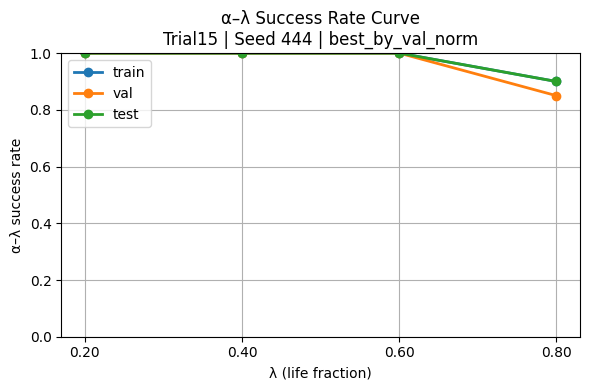

[SAVE] ./Trial15\seed_444\best_by_val_norm\alpha_lambda_eval\alpha_lambda_curve_seed444_best_by_val_norm.png


In [4]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# USER CONFIG (Trial15)
# =========================
TRIAL_DIR = r"./Trial15"

# 고정 λ를 쓸지(기존 방식) vs CSV에서 자동 추출할지 선택
USE_FIXED_LAMBDAS = True
LAM_STRS_FIXED = ["0.20", "0.40", "0.60", "0.80"]

SPLITS_ORDER = ["train", "val", "test"]
DEFAULT_CKPT = "best_by_val_norm"

# best seed/ckpt 자동 로드 (권장)
AUTO_USE_BEST_TXT = True
BEST_TXT = os.path.join(TRIAL_DIR, "BEST_MODEL_BY_VAL_NORM.txt")


# =========================
# Helpers
# =========================
def _parse_best_txt(best_txt_path: str):
    seed = None
    ckpt = None
    if not os.path.exists(best_txt_path):
        return seed, ckpt
    with open(best_txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith("seed="):
                try:
                    seed = int(line.split("=", 1)[1].strip())
                except Exception:
                    pass
            elif line.startswith("checkpoint="):
                ckpt = line.split("=", 1)[1].strip()
    return seed, ckpt


def discover_lambdas_from_columns(dfm: pd.DataFrame) -> list:
    """
    alpha_lambda_ok_{lam:.2f} 컬럼에서 lam 문자열("0.20") 자동 추출
    """
    lam = []
    pat = re.compile(r"^alpha_lambda_ok_(\d+\.\d+)$")
    for c in dfm.columns:
        m = pat.match(c)
        if m:
            lam.append(m.group(1))
    lam = sorted(set(lam), key=lambda s: float(s))
    return lam


def compute_alpha_lambda_rates_df(dfm: pd.DataFrame, lam_strs):
    """
    dfm: <split>_prognostics_metrics_per_file.csv 로드된 DF
    Returns:
      dict: {"rate_0.20":..., ... , "n_files":..., "n_valid_0.20":...}
    """
    if dfm.empty:
        return {f"rate_{ls}": np.nan for ls in lam_strs} | {"n_files": 0}

    out = {"n_files": int(len(dfm))}
    for ls in lam_strs:
        col = f"alpha_lambda_ok_{ls}"
        if col not in dfm.columns:
            out[f"rate_{ls}"] = np.nan
            out[f"n_valid_{ls}"] = 0
            continue

        v = pd.to_numeric(dfm[col], errors="coerce")  # 0/1 or NaN
        v_valid = v.dropna()
        out[f"n_valid_{ls}"] = int(len(v_valid))
        out[f"rate_{ls}"] = float(v_valid.mean()) if len(v_valid) > 0 else np.nan

    return out


# =========================
# Resolve seed/ckpt (Trial15 best)
# =========================
seed_from_txt, ckpt_from_txt = _parse_best_txt(BEST_TXT)

if AUTO_USE_BEST_TXT:
    if seed_from_txt is None:
        raise FileNotFoundError(
            f"AUTO_USE_BEST_TXT=True인데 seed를 못 읽었습니다.\n"
            f"- 기대 파일: {BEST_TXT}\n"
            f"- 먼저 best model 선택 스크립트를 돌려 BEST_MODEL_BY_VAL_NORM.txt를 생성하세요."
        )
    SEED = int(seed_from_txt)
    CKPT = str(ckpt_from_txt) if ckpt_from_txt else DEFAULT_CKPT
else:
    # 수동 모드
    SEED = 444
    CKPT = DEFAULT_CKPT

# =========================
# Paths (Trial15 export_ckpt output structure)
#   <TRIAL_DIR>/seed_<seed>/<CKPT>/<split>_prognostics_metrics_per_file.csv
# =========================
CKPT_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)

AL_DIR = os.path.join(CKPT_DIR, "alpha_lambda_eval")
SUMMARY_CSV = os.path.join(AL_DIR, f"alpha_lambda_summary_seed{SEED}_{CKPT}.csv")
OUT_PNG = os.path.join(AL_DIR, f"alpha_lambda_curve_seed{SEED}_{CKPT}.png")

if not os.path.isdir(CKPT_DIR):
    raise FileNotFoundError(f"Not found CKPT_DIR: {CKPT_DIR}")

# =========================
# Load per-split metrics & build summary
# =========================
rows = []
lam_strs_used = None

for split in SPLITS_ORDER:
    metrics_csv = os.path.join(CKPT_DIR, f"{split}_prognostics_metrics_per_file.csv")
    if not os.path.exists(metrics_csv):
        print(f"[SKIP] not found for split={split}: {metrics_csv}")
        continue

    dfm = pd.read_csv(metrics_csv)

    # λ 리스트 결정 (1회만 결정해서 모든 split에서 같은 λ로 그림)
    if lam_strs_used is None:
        if USE_FIXED_LAMBDAS:
            lam_strs_used = list(LAM_STRS_FIXED)
        else:
            lam_strs_used = discover_lambdas_from_columns(dfm)

        if not lam_strs_used:
            raise ValueError(f"No alpha_lambda_ok_* columns found in: {metrics_csv}")

    rates = compute_alpha_lambda_rates_df(dfm, lam_strs_used)
    row = {"split": split, "seed": SEED, "ckpt": CKPT, "lambdas": ",".join(lam_strs_used), **rates}
    rows.append(row)

if len(rows) == 0:
    raise FileNotFoundError(
        "No per-split metrics CSVs were found.\n"
        f"Expected like: {os.path.join(CKPT_DIR, 'test_prognostics_metrics_per_file.csv')}\n"
        "Check TRIAL_DIR/SEED/CKPT."
    )

df_sum = pd.DataFrame(rows)

# 저장
os.makedirs(AL_DIR, exist_ok=True)
df_sum.to_csv(SUMMARY_CSV, index=False)
print(f"[SAVE] {SUMMARY_CSV}")

# =========================
# Plot
# =========================
LAM = [float(x) for x in lam_strs_used]

plt.figure(figsize=(6, 4))

for split in SPLITS_ORDER:
    sub = df_sum[df_sum["split"] == split]
    if sub.empty:
        continue
    row = sub.iloc[0]

    rates = []
    for ls in lam_strs_used:
        v = row.get(f"rate_{ls}", np.nan)
        rates.append(float(v) if np.isfinite(v) else np.nan)

    plt.plot(LAM, rates, marker="o", linewidth=2, label=split)

plt.xticks(LAM, [f"{x:.2f}" for x in LAM])
plt.ylim(0.0, 1.0)
plt.xlabel("λ (life fraction)")
plt.ylabel("α–λ success rate")
plt.title(f"α–λ Success Rate Curve\nTrial15 | Seed {SEED} | {CKPT}")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()
print(f"[SAVE] {OUT_PNG}")


In [5]:
import os
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# USER CONFIG (Trial15)
# =========================
TRIAL_DIR = r"./Trial15"                 # ✅ Trial15 폴더
SPLITS = ["train", "val", "test"]        # ✅ 여러 split 한 번에

ALPHA = 0.20
LAMBDA_TO_PLOT = 0.60                   # α–λ 그림에 표시할 λ

MAX_FILES = None                        # None=모두, 아니면 예: 10

# best seed/ckpt 자동 로드 (권장)
AUTO_USE_BEST_TXT = True
BEST_TXT = os.path.join(TRIAL_DIR, "BEST_MODEL_BY_VAL_NORM.txt")
DEFAULT_CKPT = "best_by_val_norm"

# (수동 모드에서만 사용)
MANUAL_SEED = 444
MANUAL_CKPT = "best_by_val_norm"


# ============================================================
# Helpers
# ============================================================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def _parse_best_txt(best_txt_path: str) -> Tuple[Optional[int], Optional[str]]:
    seed = None
    ckpt = None
    if not os.path.exists(best_txt_path):
        return seed, ckpt

    with open(best_txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith("seed="):
                try:
                    seed = int(line.split("=", 1)[1].strip())
                except Exception:
                    pass
            elif line.startswith("checkpoint="):
                ckpt = line.split("=", 1)[1].strip()

    return seed, ckpt


def load_cycle_seq_and_metrics(seed_ckpt_dir: str, split: str):
    """
    Trial15 export_ckpt()가 만들어 둔 파일들:
      - <split>_cycle_sequence_mean.csv
      - <split>_prognostics_metrics_per_file.csv
    위치:
      <TRIAL_DIR>/seed_<seed>/<ckpt>/
    """
    seq_csv = os.path.join(seed_ckpt_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(seed_ckpt_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met


def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df


# ============================================================
# Plotters
# ============================================================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일: PH용 α-zone은 '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)  # ✅ book-style 핵심 (평행 밴드)
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일: α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


# ============================================================
# Main (multi-split)
# ============================================================
def run_for_one_split(seed_ckpt_dir: str, out_root: str, split: str, seed: int, ckpt: str):
    df_seq, df_met = load_cycle_seq_and_metrics(seed_ckpt_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(out_root, split)  # ✅ split별 폴더
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"
    title_prefix = f"Trial15 | SEED {seed} | {ckpt.upper()} | {split}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        # 필수
        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])

        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{split}] DONE -> {out_dir}")


def main():
    # -----------------------------
    # Resolve best seed/ckpt
    # -----------------------------
    seed_from_txt, ckpt_from_txt = _parse_best_txt(BEST_TXT)

    if AUTO_USE_BEST_TXT:
        if seed_from_txt is None:
            raise FileNotFoundError(
                f"AUTO_USE_BEST_TXT=True인데 seed를 못 읽었습니다.\n"
                f"- 기대 파일: {BEST_TXT}\n"
                f"- 먼저 best model 선택 스크립트를 돌려 BEST_MODEL_BY_VAL_NORM.txt를 생성하세요."
            )
        seed = int(seed_from_txt)
        ckpt = str(ckpt_from_txt) if ckpt_from_txt else DEFAULT_CKPT
    else:
        seed = int(MANUAL_SEED)
        ckpt = str(MANUAL_CKPT)

    seed_ckpt_dir = os.path.join(TRIAL_DIR, f"seed_{seed}", ckpt)
    if not os.path.isdir(seed_ckpt_dir):
        raise FileNotFoundError(f"Not found: {seed_ckpt_dir}")

    # 저장 폴더 루트 (Trial15 표준)
    out_root = os.path.join(seed_ckpt_dir, "paper_figures_bookstyle")

    for split in SPLITS:
        run_for_one_split(seed_ckpt_dir, out_root, split, seed, ckpt)

    print("\nALL DONE.")
    print("Saved under:", out_root)


if __name__ == "__main__":
    main()


[train] DONE -> ./Trial15\seed_444\best_by_val_norm\paper_figures_bookstyle\train
[val] DONE -> ./Trial15\seed_444\best_by_val_norm\paper_figures_bookstyle\val
[test] DONE -> ./Trial15\seed_444\best_by_val_norm\paper_figures_bookstyle\test

ALL DONE.
Saved under: ./Trial15\seed_444\best_by_val_norm\paper_figures_bookstyle


In [6]:
import os
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# ============================================================
# USER CONFIG
# ============================================================
@dataclass
class Cfg:
    data_dir: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"

    # Trial 결과 루트 (Trial15)
    trial_dir: str = r"./Trial15"
    seed: int = 333

    # 어떤 ckpt를 볼지: ["best_by_val_norm", "last_epoch"] 또는 하나만
    ckpts: Tuple[str, ...] = ("best_by_val_norm", "last_epoch")

    # 어떤 split을 볼지: ["train","val","test"] 중 선택
    splits: Tuple[str, ...] = ("train", "val", "test")

    # high-error 정의 (per file metric 기준)
    # 방법1: 상위 q 분위수
    high_quantile: float = 0.80
    # 방법2: 상위 k개 (q 대신 사용하려면 k를 int로 설정)
    topk: Optional[int] = None

    # persistent 조건: (ckpt, split) 조합 중 최소 몇 번 high에 걸리면 persistent로 볼지
    persistent_min_hits: int = 3

    # 클러스터 수 (KMeans)
    n_clusters: int = 4

    # 출력 폴더
    out_dir: str = r"./Trial15_rootcause_analysis"


# ============================================================
# Helpers: raw data read + feature extraction (damage/baseline/delta/tail)
# ============================================================
def read_raw_minvce(csv_path: Path) -> np.ndarray:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 1:
        raise ValueError(f"{csv_path}: needs at least 1 col")
    v = df.iloc[:, 0].astype(np.float32).to_numpy()
    return v


def _delta(v: np.ndarray, k: int = 1) -> np.ndarray:
    out = np.zeros_like(v, dtype=np.float32)
    if k <= 0:
        return out
    out[k:] = v[k:] - v[:-k]
    return out


def extract_file_level_features(v: np.ndarray) -> Dict[str, float]:
    """
    파일 전체 시퀀스에서 file-level feature를 뽑음.
    - baseline(v0) / tail level / delta stats / damage proxies (cum)
    """
    v = v.astype(np.float32)
    T = len(v)
    if T < 5:
        return {}

    v0 = float(v[0])
    v_end = float(v[-1])
    v_mean = float(np.mean(v))
    v_std = float(np.std(v, ddof=0))

    d1 = _delta(v, 1)
    dd1 = _delta(d1, 1)

    # delta stats
    d1_mean = float(np.mean(d1))
    d1_std = float(np.std(d1, ddof=0))
    d1_pos_rate = float(np.mean((d1 > 0).astype(np.float32)))
    d1_abs_mean = float(np.mean(np.abs(d1)))

    # tail stats
    tail_k = max(5, int(0.05 * T))  # 마지막 5% 또는 최소 5개
    tail = v[-tail_k:]
    tail_mean = float(np.mean(tail))
    tail_std = float(np.std(tail, ddof=0))

    # baseline-relative
    v_rel_end = float(v_end - v0)
    tail_rel_mean = float(tail_mean - v0)

    # damage proxies (누적량)
    cum_pos = float(np.sum(np.maximum(d1, 0.0)))
    cum_abs = float(np.sum(np.abs(d1)))
    cum_inc = float(np.sum(np.maximum(v - v0, 0.0)))
    cum_acc = float(np.sum(np.abs(dd1)))

    # "속도" 개념을 위해 길이로 정규화한 버전도 추가
    denom = float(max(T - 1, 1))
    cum_pos_rate = cum_pos / denom
    cum_abs_rate = cum_abs / denom
    cum_inc_rate = cum_inc / denom
    cum_acc_rate = cum_acc / denom

    return {
        "T": float(T),
        "v0": v0,
        "v_end": v_end,
        "v_mean": v_mean,
        "v_std": v_std,

        "tail_k": float(tail_k),
        "tail_mean": tail_mean,
        "tail_std": tail_std,
        "v_rel_end": v_rel_end,
        "tail_rel_mean": tail_rel_mean,

        "d1_mean": d1_mean,
        "d1_std": d1_std,
        "d1_abs_mean": d1_abs_mean,
        "d1_pos_rate": d1_pos_rate,

        "cum_pos": cum_pos,
        "cum_abs": cum_abs,
        "cum_inc": cum_inc,
        "cum_acc": cum_acc,

        "cum_pos_rate": cum_pos_rate,
        "cum_abs_rate": cum_abs_rate,
        "cum_inc_rate": cum_inc_rate,
        "cum_acc_rate": cum_acc_rate,
    }


# ============================================================
# Helpers: per-file error (from windows predictions csv)
# ============================================================
def compute_per_file_rmse_from_windows(windows_csv: Path) -> pd.DataFrame:
    """
    windows_csv columns expected:
      file, cycle, RUL_true, RUL_pred, ...
    Returns per-file RMSE/MAE + count.
    """
    df = pd.read_csv(windows_csv)
    if df.empty:
        return pd.DataFrame()

    # file-level error computed on window-level rows (간단/일관)
    df["err"] = df["RUL_pred"] - df["RUL_true"]
    g = df.groupby("file", as_index=False).agg(
        n=("err", "count"),
        mae=("err", lambda x: float(np.mean(np.abs(x)))),
        rmse=("err", lambda x: float(np.sqrt(np.mean(np.square(x))))),
        bias=("err", "mean"),
    )
    return g


def pick_high_error_files(per_file_df: pd.DataFrame, q: float, topk: Optional[int] = None) -> List[str]:
    if per_file_df.empty:
        return []
    d = per_file_df.sort_values("rmse", ascending=False).reset_index(drop=True)

    if topk is not None and int(topk) > 0:
        return d.head(int(topk))["file"].tolist()

    thr = float(d["rmse"].quantile(q))
    return d[d["rmse"] >= thr]["file"].tolist()


# ============================================================
# Main
# ============================================================
def run_rootcause(cfg: Cfg) -> None:
    out_dir = Path(cfg.out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    base = Path(cfg.trial_dir) / f"seed_{cfg.seed}"

    # 1) 모든 (ckpt, split) 조합에서 per-file RMSE 계산 + high-error 선정
    hits: Dict[str, int] = {}
    records = []

    for ckpt in cfg.ckpts:
        for split in cfg.splits:
            win_csv = base / ckpt / f"{split}_predictions_windows.csv"
            if not win_csv.exists():
                print(f"[WARN] missing: {win_csv}")
                continue

            per_file = compute_per_file_rmse_from_windows(win_csv)
            per_file["ckpt"] = ckpt
            per_file["split"] = split
            records.append(per_file)

            high_files = pick_high_error_files(per_file, q=cfg.high_quantile, topk=cfg.topk)
            for f in high_files:
                hits[f] = hits.get(f, 0) + 1

    if len(records) == 0:
        raise FileNotFoundError("No *_predictions_windows.csv found. Check cfg.trial_dir/seed/ckpt/split paths.")

    df_err_all = pd.concat(records, axis=0, ignore_index=True)
    df_err_all.to_csv(out_dir / "00_per_file_error_all_ckpt_split.csv", index=False)

    # 2) persistent high-error 파일 선정
    rows_hits = [{"file": f, "high_hits": c} for f, c in sorted(hits.items(), key=lambda x: -x[1])]
    df_hits = pd.DataFrame(rows_hits)
    df_hits.to_csv(out_dir / "01_high_error_hit_counts.csv", index=False)

    persistent = df_hits[df_hits["high_hits"] >= int(cfg.persistent_min_hits)]["file"].tolist()
    pd.DataFrame({"file": persistent}).to_csv(out_dir / "02_persistent_high_error_files.csv", index=False)

    print(f"[INFO] persistent files: {len(persistent)} (min_hits={cfg.persistent_min_hits})")

    # 3) 원본 min_vce 기반 file-level feature 추출 (전체 파일 + persistent 표시)
    raw_dir = Path(cfg.data_dir)
    raw_files = sorted([p for p in raw_dir.glob("*.csv") if p.is_file()])

    feats_rows = []
    for fp in raw_files:
        v = read_raw_minvce(fp)
        feats = extract_file_level_features(v)
        if not feats:
            continue
        feats["file"] = fp.name
        feats["is_persistent_high"] = int(fp.name in set(persistent))
        feats_rows.append(feats)

    df_feat = pd.DataFrame(feats_rows)
    df_feat.to_csv(out_dir / "03_file_level_features_damage_baseline_tail.csv", index=False)

    # 4) clustering (KMeans) on selected axes
    #    - baseline(v0), delta(d1_*), tail(tail_*), damage(cum_*)
    feature_cols = [
        "v0",
        "tail_rel_mean", "v_rel_end",
        "d1_mean", "d1_std", "d1_abs_mean", "d1_pos_rate",
        "cum_pos_rate", "cum_abs_rate", "cum_inc_rate", "cum_acc_rate",
    ]
    df_use = df_feat.dropna(subset=feature_cols).copy()
    X = df_use[feature_cols].to_numpy(dtype=np.float32)

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    km = KMeans(n_clusters=int(cfg.n_clusters), random_state=0, n_init=10)
    labels = km.fit_predict(Xs)

    df_use["cluster"] = labels.astype(int)
    df_use.to_csv(out_dir / "04_features_with_clusters.csv", index=False)

    # 5) cluster summary: persistent 비율/에러 평균 (에러는 df_err_all과 merge)
    #   - 대표로 test/best_by_val_norm 기준 RMSE도 붙여줌(있으면)
    df_err_ref = df_err_all[(df_err_all["ckpt"] == cfg.ckpts[0]) & (df_err_all["split"] == "test")][
        ["file", "rmse", "mae", "bias", "n"]
    ].rename(columns={"rmse": "rmse_ref", "mae": "mae_ref", "bias": "bias_ref", "n": "n_ref"})

    df_join = df_use.merge(df_err_ref, on="file", how="left")
    df_join.to_csv(out_dir / "05_clustered_with_ref_error.csv", index=False)

    summ = df_join.groupby("cluster", as_index=False).agg(
        n_files=("file", "count"),
        persistent_rate=("is_persistent_high", "mean"),
        rmse_ref_mean=("rmse_ref", "mean"),
        rmse_ref_std=("rmse_ref", "std"),
        v0_mean=("v0", "mean"),
        tail_rel_mean_mean=("tail_rel_mean", "mean"),
        cum_abs_rate_mean=("cum_abs_rate", "mean"),
        cum_inc_rate_mean=("cum_inc_rate", "mean"),
        d1_std_mean=("d1_std", "mean"),
    )
    summ.to_csv(out_dir / "06_cluster_summary.csv", index=False)

    # 6) PCA 2D plot
    pca = PCA(n_components=2, random_state=0)
    Z = pca.fit_transform(Xs)
    df_join["pca1"] = Z[:, 0]
    df_join["pca2"] = Z[:, 1]
    df_join.to_csv(out_dir / "07_clustered_with_pca.csv", index=False)

    plt.figure()
    for c in sorted(df_join["cluster"].unique()):
        sub = df_join[df_join["cluster"] == c]
        plt.scatter(sub["pca1"], sub["pca2"], s=20, label=f"cluster {c}", alpha=0.7)
    # persistent 표시(테두리 강조)
    subp = df_join[df_join["is_persistent_high"] == 1]
    if len(subp) > 0:
        plt.scatter(subp["pca1"], subp["pca2"], s=80, facecolors="none", edgecolors="k", linewidths=1.5, label="persistent high")

    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.title("File clusters on baseline/Δv/tail/damage-proxy axes")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_dir / "08_pca_clusters.png", dpi=200)
    plt.close()

    # 7) persistent 파일만 따로: 어떤 cluster에 몰리는지 + 상위 특징
    df_p = df_join[df_join["is_persistent_high"] == 1].copy()
    df_p.to_csv(out_dir / "09_persistent_only_with_features.csv", index=False)

    if len(df_p) > 0:
        dist = df_p["cluster"].value_counts().sort_index()
        dist.to_csv(out_dir / "10_persistent_cluster_distribution.csv", header=["count"])

        # persistent vs others mean shift (표준화된 공간에서)
        Xs_all = pd.DataFrame(Xs, columns=[f"z_{c}" for c in feature_cols])
        Xs_all["is_persistent_high"] = df_use["is_persistent_high"].values
        mu_p = Xs_all[Xs_all["is_persistent_high"] == 1].mean(numeric_only=True)
        mu_o = Xs_all[Xs_all["is_persistent_high"] == 0].mean(numeric_only=True)
        shift = (mu_p - mu_o).sort_values(ascending=False)
        shift.to_csv(out_dir / "11_persistent_minus_others_mean_shift_z.csv", header=["mean_shift_z"])

    print("\n[SAVED]")
    print(" -", out_dir / "02_persistent_high_error_files.csv")
    print(" -", out_dir / "03_file_level_features_damage_baseline_tail.csv")
    print(" -", out_dir / "06_cluster_summary.csv")
    print(" -", out_dir / "08_pca_clusters.png")
    print(" -", out_dir / "11_persistent_minus_others_mean_shift_z.csv")


if __name__ == "__main__":
    cfg = Cfg(
        data_dir=r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100",
        trial_dir=r"./Trial15",
        seed=333,
        ckpts=("best_by_val_norm", "last_epoch"),
        splits=("train", "val", "test"),
        high_quantile=0.80,
        topk=None,
        persistent_min_hits=3,
        n_clusters=4,
        out_dir=r"./Trial15_rootcause_analysis",
    )
    run_rootcause(cfg)


[INFO] persistent files: 0 (min_hits=3)


c:\Users\11HOME_AHCI\anaconda3\envs\igbt_rnn\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



[SAVED]
 - Trial15_rootcause_analysis\02_persistent_high_error_files.csv
 - Trial15_rootcause_analysis\03_file_level_features_damage_baseline_tail.csv
 - Trial15_rootcause_analysis\06_cluster_summary.csv
 - Trial15_rootcause_analysis\08_pca_clusters.png
 - Trial15_rootcause_analysis\11_persistent_minus_others_mean_shift_z.csv
